In [76]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, recall_score, precision_score, 
    roc_auc_score, f1_score, classification_report, log_loss, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.optimizers.legacy import Adam, SGD, RMSprop
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt
import seaborn as sns


## 1. Load data, visualise it and identify erroneous values

In [35]:
df_diabetes = pd.read_csv('diabetes.csv')
df_diabetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [36]:
df_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [37]:
df_diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [38]:
# Extract the feature names
feature_names = df_diabetes.columns[0:-1].tolist()
print(feature_names)

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


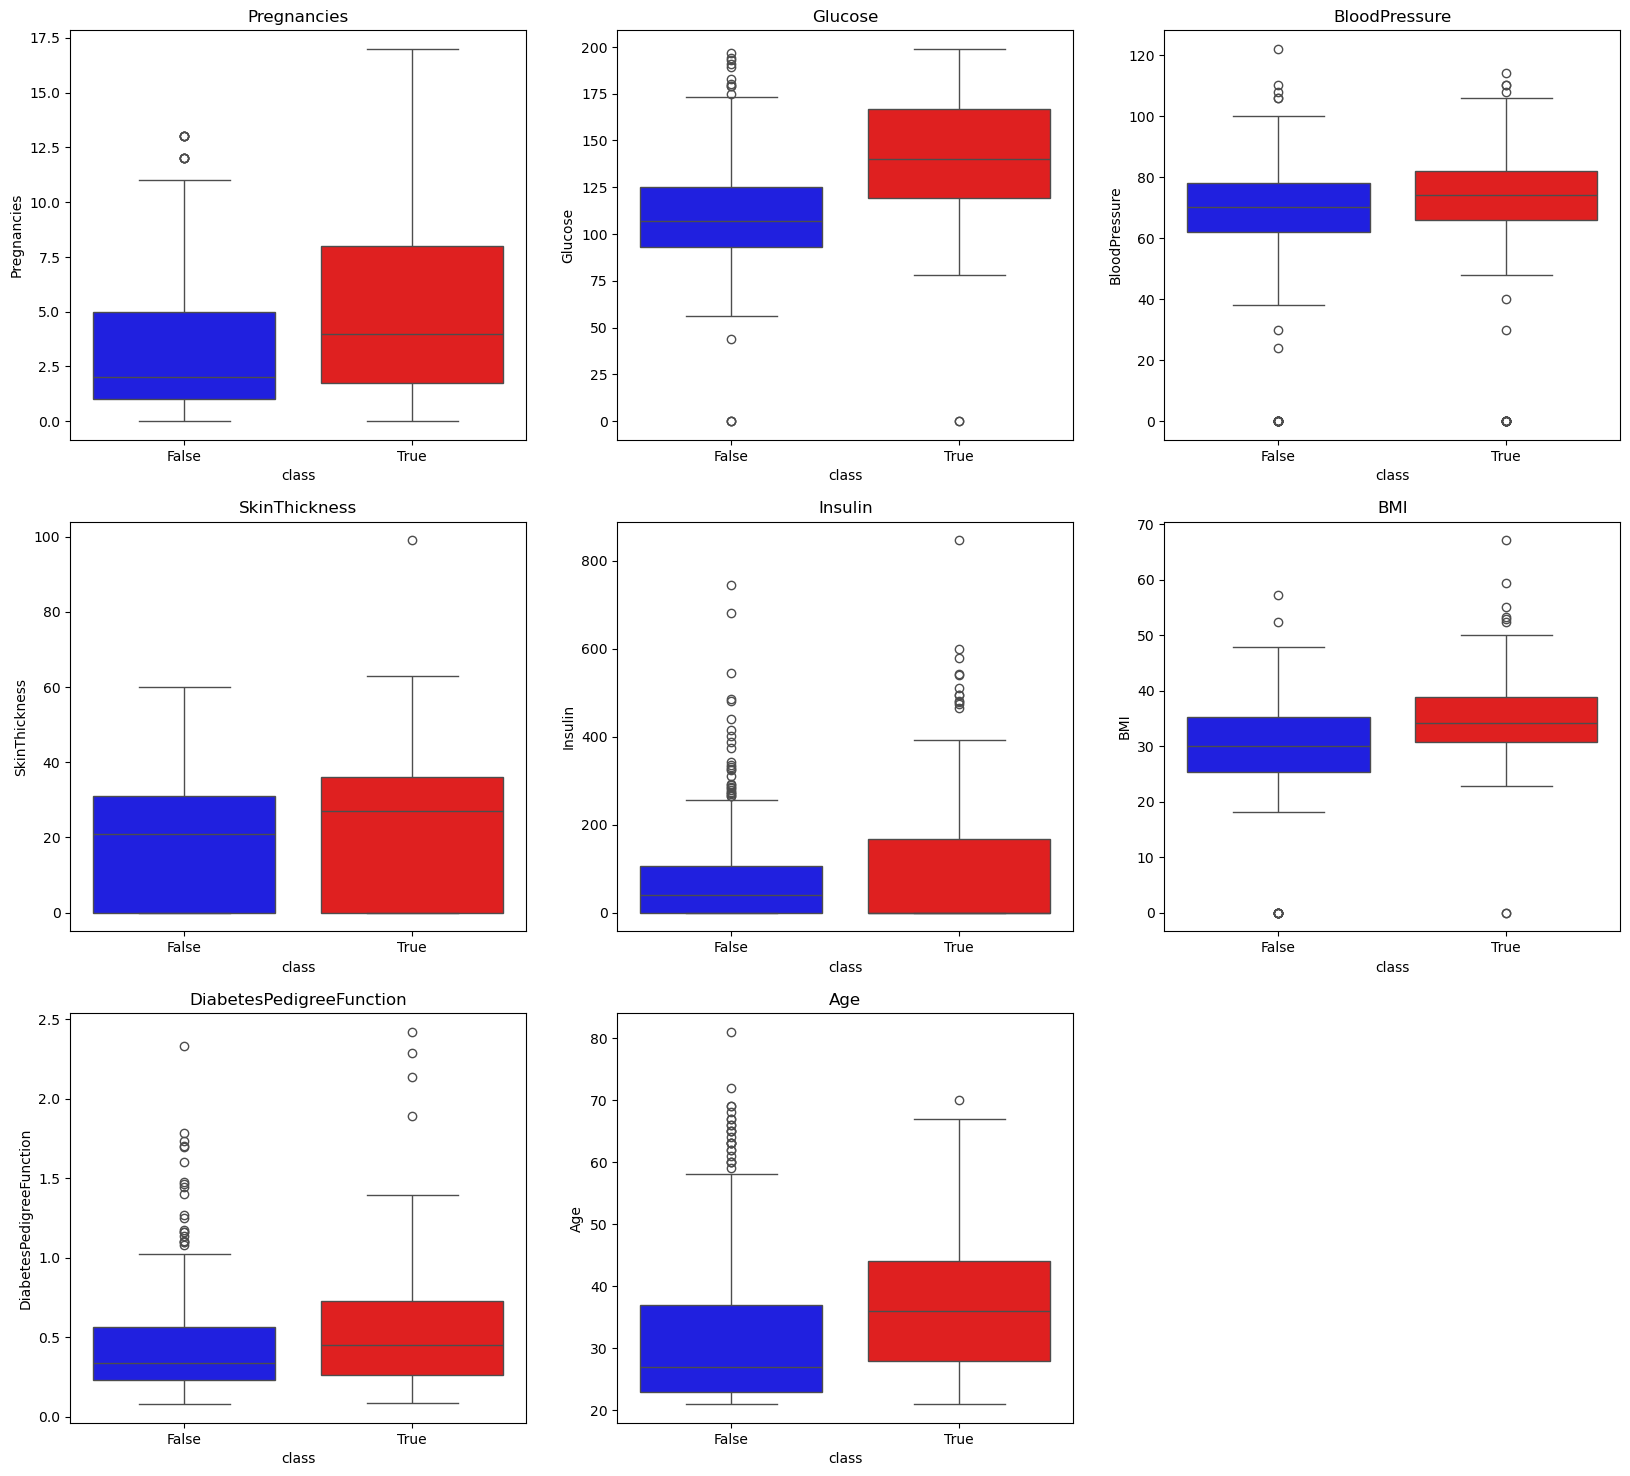

In [39]:
# Create the grid for the boxplots
fig, axes = plt.subplots(8, 3, figsize=(20, 50))
axes = axes.flatten()

# Create the boxplots
for i, feature in enumerate(feature_names):
    sns.boxplot(x='Outcome', y=feature, data=df_diabetes, hue='Outcome', ax=axes[i], palette={1: 'red', 0: 'blue'})
    axes[i].set_title(feature)
    axes[i].set_xlabel('class',  fontsize=10)
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['False', 'True'], fontsize=10)
    axes[i].set_ylabel(feature, fontsize=10)
    axes[i].legend_.remove()

for j in range(len(feature_names), len(axes)):
    fig.delaxes(axes[j])

plt.show()

In [40]:
invalid_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df_diabetes[invalid_zeros] = df_diabetes[invalid_zeros].replace(0, np.nan)

In [41]:
features = df_diabetes[feature_names]
labels = df_diabetes['Outcome']

In [42]:
# Outlier Blood Pressure
outlier_row = df_diabetes[df_diabetes['BloodPressure'] < 40]
print(outlier_row)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
18             1    103.0           30.0           38.0     83.0  43.3   
125            1     88.0           30.0           42.0     99.0  55.0   
597            1     89.0           24.0           19.0     25.0  27.8   
599            1    109.0           38.0           18.0    120.0  23.1   

     DiabetesPedigreeFunction  Age  Outcome  
18                      0.183   33        0  
125                     0.496   26        1  
597                     0.559   21        0  
599                     0.407   26        0  


In [43]:
df_diabetes.loc[df_diabetes['BloodPressure'] < 40, 'BloodPressure'] = np.nan

In [44]:
# Outlier Skin thickness
outlier_row = df_diabetes[df_diabetes['SkinThickness'] == 99]
print(outlier_row)


     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
579            2    197.0           70.0           99.0      NaN  34.7   

     DiabetesPedigreeFunction  Age  Outcome  
579                     0.575   62        1  


In [45]:
df_diabetes.loc[df_diabetes['SkinThickness'] == 99, 'SkinThickness'] = np.nan

In [46]:
# Outlier Insulin
outlier_row = df_diabetes[df_diabetes['Insulin'] > 400]
print(outlier_row)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
8              2    197.0           70.0           45.0    543.0  30.5   
13             1    189.0           60.0           23.0    846.0  30.1   
111            8    155.0           62.0           26.0    495.0  34.0   
153            1    153.0           82.0           42.0    485.0  40.6   
186            8    181.0           68.0           36.0    495.0  30.1   
220            0    177.0           60.0           29.0    478.0  34.6   
228            4    197.0           70.0           39.0    744.0  36.7   
247            0    165.0           90.0           33.0    680.0  52.3   
248            9    124.0           70.0           33.0    402.0  35.4   
286            5    155.0           84.0           44.0    545.0  38.7   
370            3    173.0           82.0           48.0    465.0  38.4   
392            1    131.0           64.0           14.0    415.0  23.7   
409            1    172.0           68

In [47]:
df_diabetes.loc[df_diabetes['Insulin'] > 400, 'Insulin'] = np.nan

In [48]:
# Outlier BMI?
outlier_row = df_diabetes[df_diabetes['BMI'] > 60]
print(outlier_row)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
177            0    129.0          110.0           46.0    130.0  67.1   

     DiabetesPedigreeFunction  Age  Outcome  
177                     0.319   26        1  


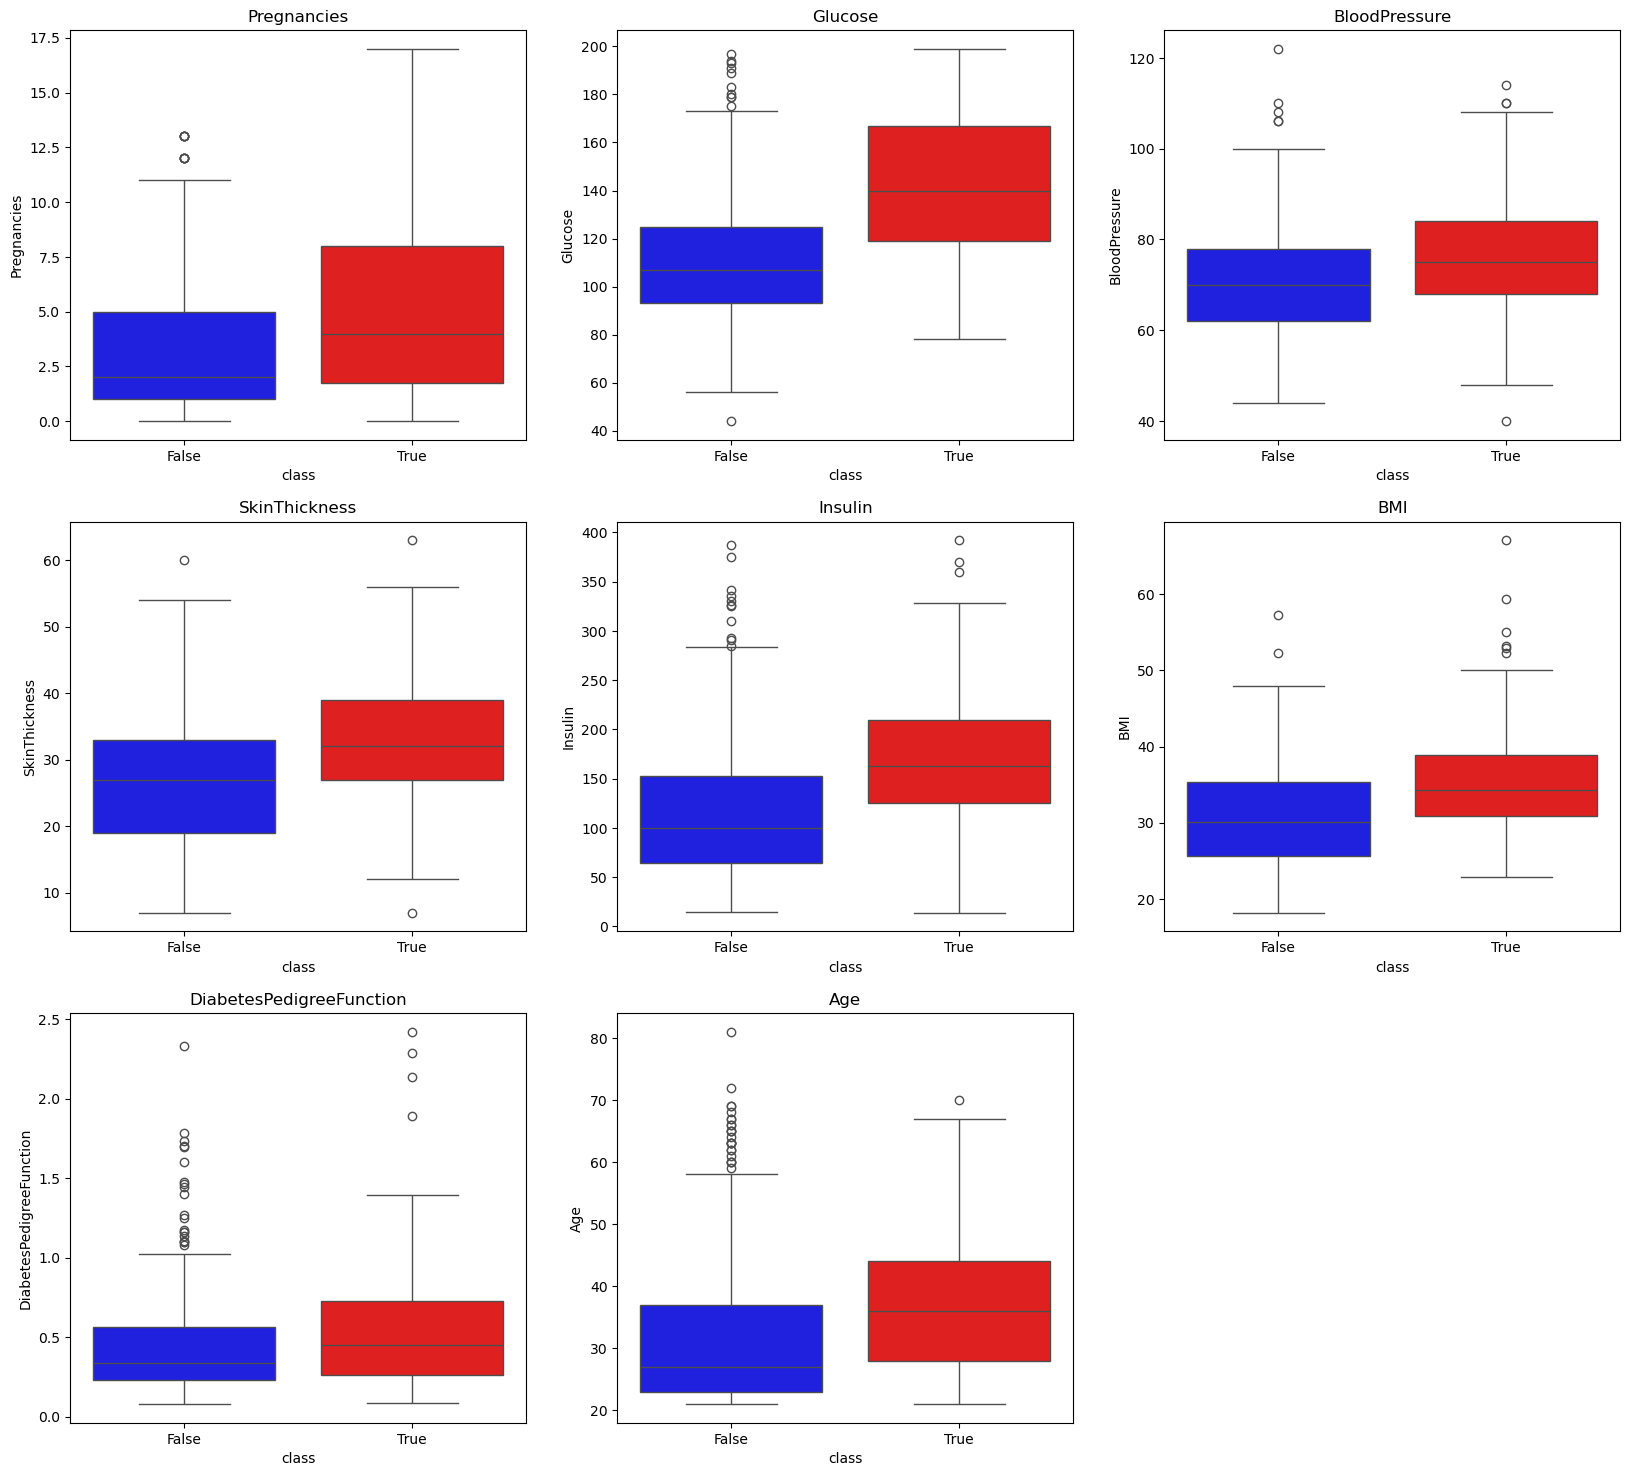

In [49]:
# Create the grid for the boxplots
fig, axes = plt.subplots(8, 3, figsize=(20, 50))
axes = axes.flatten()

# Create the boxplots
for i, feature in enumerate(feature_names):
    sns.boxplot(x='Outcome', y=feature, data=df_diabetes, hue='Outcome', ax=axes[i], palette={1: 'red', 0: 'blue'})
    axes[i].set_title(feature)
    axes[i].set_xlabel('class',  fontsize=10)
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['False', 'True'], fontsize=10)
    axes[i].set_ylabel(feature, fontsize=10)
    axes[i].legend_.remove()

for j in range(len(feature_names), len(axes)):
    fig.delaxes(axes[j])

plt.show()

In [50]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)

In [51]:
X_train.shape, X_test.shape

((614, 8), (154, 8))

In [52]:
# Defining a preprocessing pipeline with an imputer and a scaler
preprocessor = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', RobustScaler())
])

# It will be used later in the baseline models
# For that, a function to create pipelines can help
def create_pipeline(model):
    return Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

### Implement models

In [72]:
# Defining a baseline model that makes random predictions
def random_baseline_model(X_train, y_train, preprocessor, cv=5):
    """
    A function that creates a baseline model that makes random predictions.
    
    Parameters:
        X_train: The training data.
        y_train: The training labels.
        preprocessor: The preprocessing pipeline.
    Returns:
        random_pred: The random predictions.
    """
    # Fit and transform the training data
    X_train_prep = preprocessor.fit_transform(X_train)

    # Initialize cross-validation
    stratified_kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    # Initialize the model
    random_model = DummyClassifier(strategy='uniform', random_state=42)

    # Perform cross-validation
    random_pred = cross_val_predict(random_model, X_train_prep, y_train, cv=stratified_kfold)

    return random_pred

In [73]:
# Evaluate the random baseline model's performance
def evaluate_performance(y_true, y_pred):
    """
    A function to evaluate the performance of the baseline model.
    
    Parameters:
        y_true: The true labels.
        y_pred: The predicted labels by the baseline model.
    Returns:
        None: Prints various metrics.
    """
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'balanced_accuracy': balanced_accuracy_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred, average='macro'),
        'precision': precision_score(y_true, y_pred, average='macro'),
        'f1': f1_score(y_true, y_pred, average='macro'),
        'roc_auc': roc_auc_score(y_true, y_pred, multi_class='ovr')
    }

    for metric, score in metrics.items():
        print(f'{metric}: {score:.4f}')

In [75]:
# Generate random predictions with the baseline model
random_predictions = random_baseline_model(X_train, y_train, preprocessor)

# Evaluate the performance of the random baseline model
evaluate_performance(y_train, random_predictions)

accuracy: 0.4739
balanced_accuracy: 0.4996
recall: 0.4996
precision: 0.4996
f1: 0.4716
roc_auc: 0.4996


In [58]:
# Fit the random baseline model
random_pred = random_baseline_model(X_train, y_train, preprocessor)

In [27]:
def Perceptron(optimizer='adam', input_dim=len(feature_names), activation='sigmoid', loss='binary_crossentropy', regularizer=None, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(1, input_dim=input_dim, activation=activation, kernel_regularizer=regularizer))
    
    # Customize optimizer with the learning rate
    if optimizer == 'adam':
        optimizer_instance = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer_instance = SGD(learning_rate=learning_rate)
    elif optimizer == 'RMSprop':
        optimizer_instance = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer}")
    
    model.compile(optimizer=optimizer_instance, loss=loss, metrics=['accuracy'])
    return model

In [28]:
def create_pipeline(preprocessor, model):
    return Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

In [29]:
# Define the model using KerasClassifier wrapper
model = KerasClassifier(build_fn=Perceptron, epochs=1000, verbose=0)  # Set `epochs` here

/var/folders/sk/816rf7z11wb24jqhcn350qzh0000gn/T/ipykernel_70906/2314920567.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=Perceptron, epochs=1000, verbose=0)  # Set `epochs` here


In [30]:
# Create the pipeline with the perceptron model and preprocessor
pipeline = create_pipeline(preprocessor, model)

In [31]:
param_grid = {
    'model__optimizer': ['adam', 'sgd', 'RMSprop'],
    'model__activation': ['sigmoid', 'relu', 'tanh', LeakyReLU()],
    'model__regularizer': [None, regularizers.l1(0.01), regularizers.l2(0.01)],
    'model__learning_rate': [0.001, 0.01, 0.1]  # Different learning rates to test
}

In [32]:
grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, return_train_score=True)
grid.fit(X_train, y_train)

2024-10-05 22:07:39.019636: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-10-05 22:07:39.046682: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-10-05 22:07:39.126077: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-10-05 22:07:39.130025: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-10-05 22:07:39.133101: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-10-05 22:07:39.219738: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-10-05 22:07:39.288558: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-10-05 22:07:39.314492: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-10-05 22:07:39.317666: W tensorflow

16/16 [==============================] - 0s 547us/step


/opt/anaconda3/envs/umlt/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


4/4 [==============================] - 0s 367us/step


2024-10-05 22:17:23.207401: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


16/16 [==============================] - 0s 1ms/step


2024-10-05 22:17:24.980783: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


16/16 [==============================] - 0s 760us/step


2024-10-05 22:17:28.450141: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


16/16 [==============================] - 0s 943us/step


2024-10-05 22:17:33.479218: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


16/16 [==============================] - 0s 869us/step


2024-10-05 22:17:38.072422: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


16/16 [==============================] - 0s 207us/step


2024-10-05 22:17:46.244626: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('imputer',
                                                         KNNImputer()),
                                                        ('scaler',
                                                         RobustScaler())])),
                                       ('model',
                                        <keras.wrappers.scikit_learn.KerasClassifier object at 0x30f053410>)]),
             n_jobs=-1,
             param_grid={'model__activation': ['sigmoid', 'relu', 'tanh',
                                               <keras.layers.activation.leaky_relu.LeakyReLU object at 0x30edad5d0>],
                         'model__learning_rate': [0.001, 0.01, 0.1],
                         'model__optimizer': ['adam', 'sgd', 'RMSprop'],
                         'model__regularizer': [None,
                                                <keras.regularizers.L1 object at 0x30ef71810>,
                                                <keras.regularizers.L2 object at 0x308d885d0>]},
             return_train_score=True, scoring='accuracy')

In [61]:
def evaluate_all_models(grid_search, X_train, y_train):
    results = []
    best_score = 0
    best_index = None
    
    # Ensure `return_train_score=True` was used when initializing GridSearchCV
    if not grid_search.return_train_score:
        raise ValueError("Please initialize GridSearchCV with return_train_score=True to capture train scores.")
    
    # Loop through each model and parameter set tested in the grid search
    for i in range(len(grid_search.cv_results_['params'])):
        params = grid_search.cv_results_['params'][i]
        
        # Get cross-validated metrics
        mean_train_accuracy = grid_search.cv_results_['mean_train_score'][i]
        mean_val_accuracy = grid_search.cv_results_['mean_test_score'][i]
        std_val_accuracy = grid_search.cv_results_['std_test_score'][i]

        # Calculate train and validation losses (assuming negative log-loss was used as the scoring)
        mean_train_loss = -grid_search.cv_results_['mean_train_score'][i] if 'mean_train_score' in grid_search.cv_results_ else None
        mean_val_loss = -grid_search.cv_results_['mean_test_score'][i] if 'mean_test_score' in grid_search.cv_results_ else None

        # Store results
        results.append({
            "params": params,
            "train_accuracy": mean_train_accuracy,
            "val_accuracy": mean_val_accuracy,
            "val_accuracy_std": std_val_accuracy,
            "train_loss": mean_train_loss,
            "val_loss": mean_val_loss
        })
        
        # Track the best model based on validation accuracy
        if mean_val_accuracy > best_score:
            best_score = mean_val_accuracy
            best_index = i
    
    # Print results for all models
    for result in results:
        print(f"\nParameters: {result['params']}")
        print(f"Train Accuracy: {result['train_accuracy']:.4f}, Val Accuracy: {result['val_accuracy']:.4f} ± {result['val_accuracy_std']:.4f}")
        print(f"Train Loss: {result['train_loss']:.4f}, Val Loss: {result['val_loss']:.4f}")
    
    # Get the best model from the grid search
    best_model = grid_search.best_estimator_
    
    # Calculate the loss for the best model on the training data
    if hasattr(best_model, "predict_proba"):
        final_train_proba = best_model.predict_proba(X_train)[:, 1]
        final_train_loss = log_loss(y_train, final_train_proba)
    else:
        final_train_predictions = best_model.predict(X_train)
        final_train_loss = log_loss(y_train, final_train_predictions)

    # Highlight the best model parameters and final loss
    print("\nBest Model Parameters:", grid_search.cv_results_['params'][best_index])
    print(f"Best Validation Accuracy: {best_score:.4f}")
    print(f"Final Train Loss of Best Model: {final_train_loss:.4f}")
    
    return results


In [62]:
all_results = evaluate_all_models(grid, X_train, y_train)



Parameters: {'model__activation': 'sigmoid', 'model__learning_rate': 0.001, 'model__optimizer': 'adam', 'model__regularizer': None}
Train Accuracy: 0.7932, Val Accuracy: 0.7899 ± 0.0146
Train Loss: -0.7932, Val Loss: -0.7899

Parameters: {'model__activation': 'sigmoid', 'model__learning_rate': 0.001, 'model__optimizer': 'adam', 'model__regularizer': <keras.regularizers.L1 object at 0x30ef71810>}
Train Accuracy: 0.7895, Val Accuracy: 0.7802 ± 0.0232
Train Loss: -0.7895, Val Loss: -0.7802

Parameters: {'model__activation': 'sigmoid', 'model__learning_rate': 0.001, 'model__optimizer': 'adam', 'model__regularizer': <keras.regularizers.L2 object at 0x308d885d0>}
Train Accuracy: 0.7875, Val Accuracy: 0.7785 ± 0.0152
Train Loss: -0.7875, Val Loss: -0.7785

Parameters: {'model__activation': 'sigmoid', 'model__learning_rate': 0.001, 'model__optimizer': 'sgd', 'model__regularizer': None}
Train Accuracy: 0.7777, Val Accuracy: 0.7639 ± 0.0254
Train Loss: -0.7777, Val Loss: -0.7639

Parameters: {'

In [66]:
# Assuming grid_search is the trained GridSearchCV object

# Get the best estimator
best_model = grid.best_estimator_

# Retrain the best model on the entire training set
history = best_model.fit(X_train, y_train)

# Evaluate on the test set
test_predictions = best_model.predict(X_test)
if hasattr(best_model, "predict_proba"):
    test_proba_predictions = best_model.predict_proba(X_test)[:, 1]
    test_loss = log_loss(y_test, test_proba_predictions)
else:
    test_loss = log_loss(y_test, test_predictions)

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, test_predictions)

# Print test set results
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


5/5 [==============================] - 0s 668us/step
Test Accuracy: 0.6948
Test Loss: 0.5139


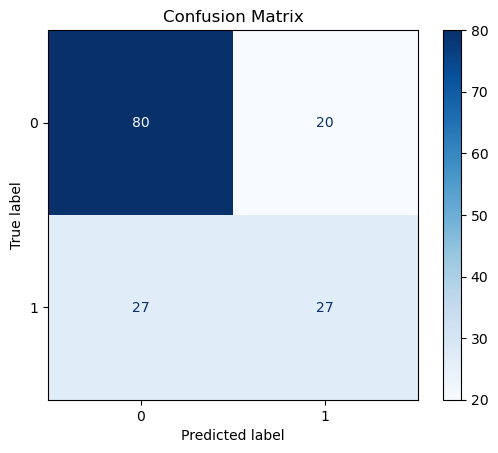

In [65]:
# Create a confusion matrix
cm = confusion_matrix(y_test, test_predictions)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()